# Alternative Models

This notebook considers some alternative models to handle the outliers found in the Leinhardt data in the [previous notebook](http://localhost:8888/notebooks/w03-07c-model-checking.ipynb).

Simplest approach is to get rid of the outliers if we believe they are not representative of the data. Here we assume that the outliers belong in the model, and we want to update our model to explain these outliers.

This notebook covers the videos **Alternative Models** and **Deviance Information Criteria (DIC)** in Lesson 7 of the course.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [3]:
try:
    leinhardt_df = pd.read_csv("Leinhardt.csv")
except:
    leinhardt_df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/carData/Leinhardt.csv")
    leinhardt_df.to_csv("Leinhardt.csv")
    
leinhardt_df.head()

,Unnamed: 0,Unnamed: 0.1,income,infant,region,oil
0,0,Australia,3426,26.7,Asia,no
1,1,Austria,3350,23.7,Europe,no
2,2,Belgium,3346,17.0,Europe,no
3,3,Canada,4751,16.8,Americas,no
4,4,Denmark,5029,13.5,Europe,no


In [4]:
leinhardt_df["log_income"] = np.log(leinhardt_df["income"])
leinhardt_df["log_infant"] = np.log(leinhardt_df["infant"])

leinhardt_df.dropna(subset=["log_income", "log_infant"], inplace=True)

In [5]:
x = leinhardt_df["log_income"].values
y = leinhardt_df["log_infant"].values
x.shape, y.shape

((101,), (101,))

## Baseline Model (from previous notebook)

In [6]:
init_params = {
    "mu_0": 0,
    "sigma_0": 1e6,
    "alpha_0": 2.5,
    "beta_0": 0.04
}

n_tune = 1000
n_iter = 5000
n_chains = 3

baseline_model = pm.Model()
with baseline_model:
    beta = pm.Normal("beta", mu=init_params["mu_0"], sigma=init_params["sigma_0"], shape=2)
    sigma2 = pm.InverseGamma("sigma2", alpha=init_params["alpha_0"], beta=init_params["beta_0"])

    sigma = np.sqrt(sigma2)
    mu = beta[0] + beta[1] * x
    
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    trace_b = pm.sample(n_iter, tune=n_tune, chains=n_chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma2, beta]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:24<00:00, 744.05draws/s] 


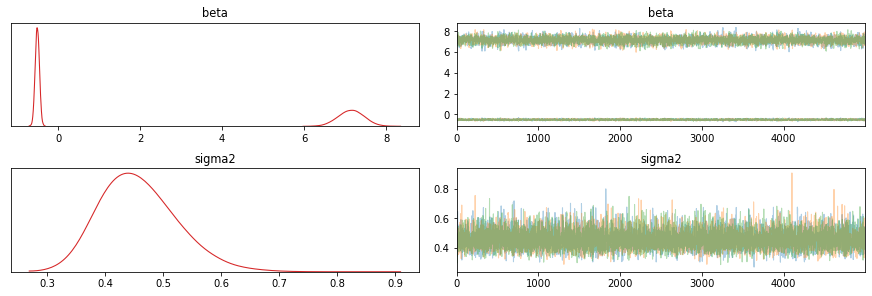

In [7]:
_ = pm.traceplot(trace_b, combined=True)

In [8]:
pm.gelman_rubin(trace_b)

<xarray.Dataset>
Dimensions:     (beta_dim_0: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (beta_dim_0) float64 1.0 1.0
    sigma2      float64 1.0

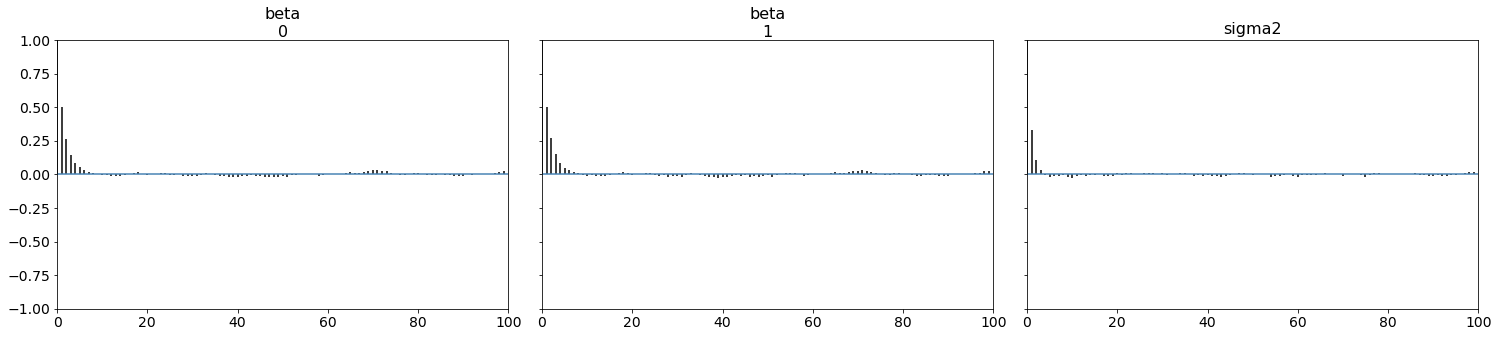

In [9]:
_ = pm.autocorrplot(trace_b, combined=True)

In [10]:
pm.effective_n(trace_b)

<xarray.Dataset>
Dimensions:     (beta_dim_0: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (beta_dim_0) float64 4.707e+03 4.72e+03
    sigma2      float64 7.756e+03

In [11]:
pm.summary(trace_b)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],7.149,0.314,6.555,7.723,0.005,0.003,4670.0,4658.0,4707.0,5062.0,1.0
beta[1],-0.512,0.051,-0.608,-0.419,0.001,0.001,4679.0,4649.0,4720.0,5276.0,1.0
sigma2,0.459,0.065,0.350,0.588,0.001,0.001,7762.0,7703.0,7756.0,7312.0,1.0


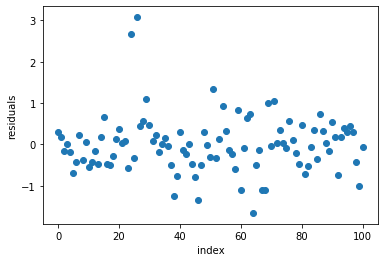

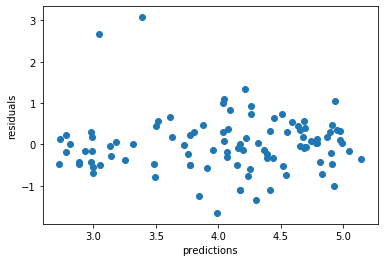

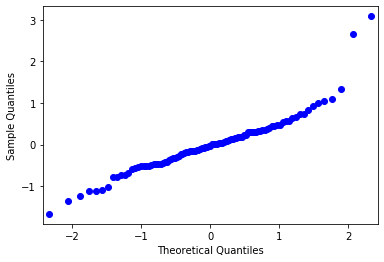

In [12]:
beta = np.mean(trace_b.get_values("beta", combine=True), axis=0)
preds = beta[0] + beta[1] * x
resids = y - preds

plt.xlabel("index")
plt.ylabel("residuals")
plt.scatter(np.arange(len(resids)), resids)
_ = plt.show()

plt.xlabel("predictions")
plt.ylabel("residuals")
plt.scatter(preds, resids)
_ = plt.show()

_ = sm.qqplot(resids)

## Alternative Model 1


In this alternative model, we look for additional covariates / explanatory variables that explain the outliers.

We know that one of our explanatory variables is `oil`, yes if country is oil-exporting and no if it is not. Both our outliers, Saudi Arabia and Libya, are oil exporting countries, so including this variable in the model might explain the outliers better.

### Findings:

* There is a positive correlation between oil production and infant mortality.
* Residual plots show improvement -- outliers are closer to the rest of the distribution than it was in the baseline model.

In [13]:
leinhardt_df.loc[leinhardt_df["oil"] == 'no', 'oil_i'] = 0
leinhardt_df.loc[leinhardt_df["oil"] == 'yes', 'oil_i'] = 1

leinhardt_df.head()

,Unnamed: 0,Unnamed: 0.1,income,infant,region,oil,log_income,log_infant,oil_i
0,0,Australia,3426,26.7,Asia,no,8.139149,3.284664,0.0
1,1,Austria,3350,23.7,Europe,no,8.116716,3.165475,0.0
2,2,Belgium,3346,17.0,Europe,no,8.115521,2.833213,0.0
3,3,Canada,4751,16.8,Americas,no,8.466110,2.821379,0.0
4,4,Denmark,5029,13.5,Europe,no,8.522976,2.602690,0.0


In [14]:
x0 = np.ones(len(leinhardt_df))
x1 = leinhardt_df["log_income"].values
x2 = leinhardt_df["oil_i"].values
X = np.vstack((x0, x1, x2)).T

y = leinhardt_df["log_infant"].values
X.shape, y.shape

((101, 3), (101,))

In [15]:
init_params = {
    "mu_0": 0,
    "sigma_0": 1e6,
    "alpha_0": 2.5,
    "beta_0": 0.04
}

n_tune = 1000
n_iter = 5000
n_chains = 3

alt_model_1 = pm.Model()
with alt_model_1:
    beta = pm.Normal("beta", mu=init_params["mu_0"], sigma=init_params["sigma_0"], shape=3)
    sigma2 = pm.InverseGamma("sigma2", alpha=init_params["alpha_0"], beta=init_params["beta_0"])

    sigma = np.sqrt(sigma2)
    mu = beta[0] * X[:, 0] + beta[1] * X[:, 1] + beta[2] * X[:, 2]
    
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    trace_a1 = pm.sample(n_iter, tune=n_tune, chains=n_chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma2, beta]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:28<00:00, 634.61draws/s] 


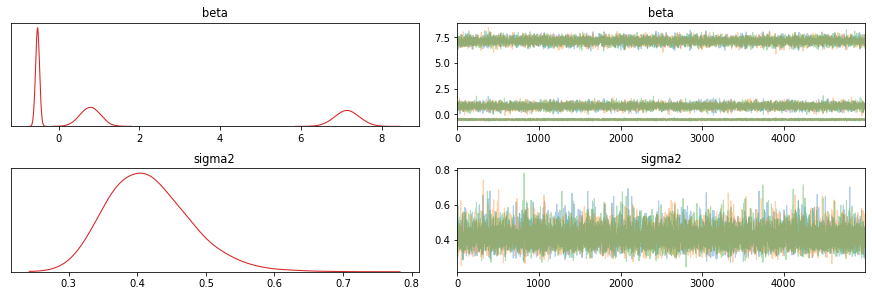

In [16]:
_ = pm.traceplot(trace_a1, combined=True)

In [17]:
pm.gelman_rubin(trace_a1)

<xarray.Dataset>
Dimensions:     (beta_dim_0: 3)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2
Data variables:
    beta        (beta_dim_0) float64 1.0 1.0 1.0
    sigma2      float64 1.0

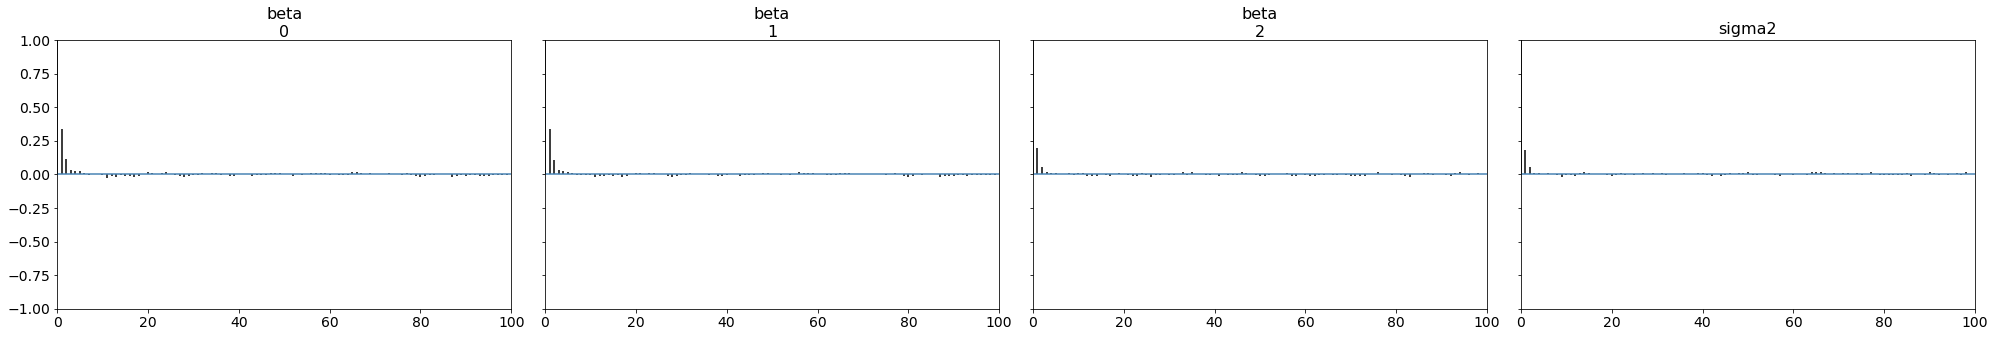

In [18]:
_ = pm.autocorrplot(trace_a1, combined=True)

In [19]:
pm.effective_n(trace_a1)

<xarray.Dataset>
Dimensions:     (beta_dim_0: 3)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2
Data variables:
    beta        (beta_dim_0) float64 7.223e+03 7.307e+03 9.277e+03
    sigma2      float64 1.009e+04

In [20]:
pm.summary(trace_a1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],7.142,0.295,6.608,7.721,0.003,0.002,7214.0,7213.0,7223.0,8194.0,1.0
beta[1],-0.521,0.048,-0.614,-0.433,0.001,0.000,7300.0,7300.0,7307.0,7927.0,1.0
beta[2],0.784,0.246,0.318,1.233,0.003,0.002,9234.0,8909.0,9277.0,7839.0,1.0
sigma2,0.418,0.060,0.313,0.532,0.001,0.000,9726.0,9335.0,10089.0,8673.0,1.0


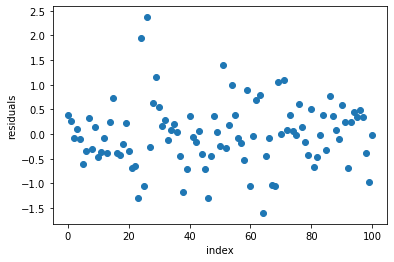

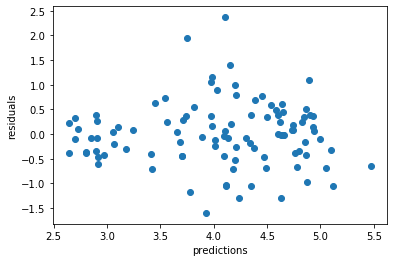

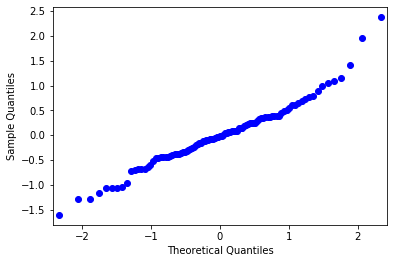

In [21]:
beta = np.mean(trace_a1.get_values("beta", combine=True), axis=0)
preds = beta[0] * X[:, 0] + beta[1] * X[:, 1] + beta[2] * X[:, 2]
resids = y - preds

plt.xlabel("index")
plt.ylabel("residuals")
plt.scatter(np.arange(len(resids)), resids)
_ = plt.show()

plt.xlabel("predictions")
plt.ylabel("residuals")
plt.scatter(preds, resids)
_ = plt.show()

_ = sm.qqplot(resids)

## Alternative Model 2

We will change the distribution of likelihood from Normal to T distribution. The T distribution has a heavier tail and greater ability to accomodate outliers in the distribution.

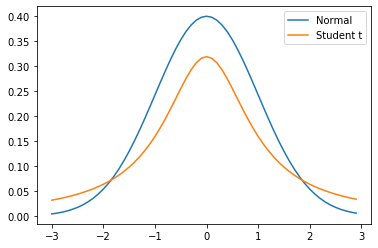

In [22]:
xs = np.arange(-3, 3, 0.1)

plt.plot(xs, stats.norm.pdf(xs, loc=0, scale=1), label="Normal")
plt.plot(xs, stats.t.pdf(xs, 1, loc=0, scale=1), label="Student t")
plt.legend(loc="best")
_ = plt.show()

In [23]:
init_params = {
    "mu_0": 0,
    "sigma_0": 1e6,
    "alpha_0": 2.5,
    "beta_0": 0.04,
    "df_0": 1.0
}

n_tune = 1000
n_iter = 5000
n_chains = 3

alt_model_2 = pm.Model()
with alt_model_2:
    beta = pm.Normal("beta", mu=init_params["mu_0"], sigma=init_params["sigma_0"], shape=3)
    tau = pm.InverseGamma("tau", alpha=init_params["alpha_0"], beta=init_params["beta_0"])
    df = pm.Exponential("df", lam=init_params["df_0"])

    sigma = np.sqrt((tau * df) / (df - 2))
    mu = beta[0] * X[:, 0] + beta[1] * X[:, 1] + beta[2] * X[:, 2]
    
    y_obs = pm.StudentT("y_obs", nu=df, mu=mu, sigma=tau, observed=y)
    
    trace_a2 = pm.sample(n_iter, tune=n_tune, chains=n_chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [df, tau, beta]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:32<00:00, 550.07draws/s]
The acceptance probability does not match the target. It is 0.8797034933569138, but should be close to 0.8. Try to increase the number of tuning steps.


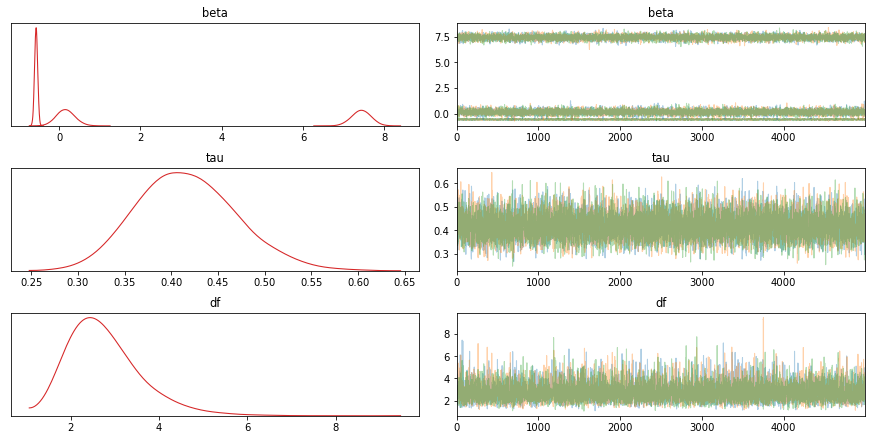

In [24]:
_ = pm.traceplot(trace_a2, combined=True)

In [25]:
pm.gelman_rubin(trace_a2)

<xarray.Dataset>
Dimensions:     (beta_dim_0: 3)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2
Data variables:
    beta        (beta_dim_0) float64 1.0 1.0 1.0
    tau         float64 1.001
    df          float64 1.0

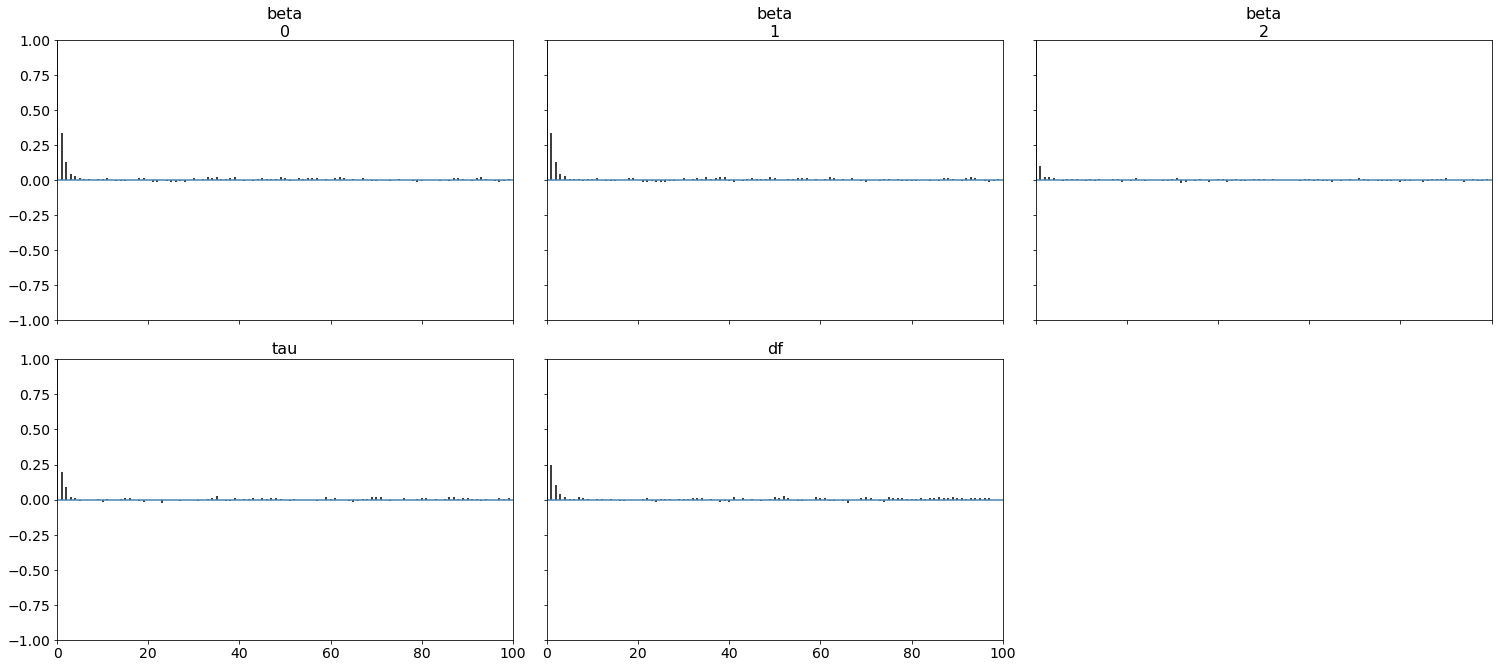

In [26]:
_ = pm.autocorrplot(trace_a2, combined=True)

In [27]:
pm.effective_n(trace_a2)

<xarray.Dataset>
Dimensions:     (beta_dim_0: 3)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2
Data variables:
    beta        (beta_dim_0) float64 7.062e+03 7.112e+03 1.131e+04
    tau         float64 9.189e+03
    df          float64 8.358e+03

In [28]:
pm.summary(trace_a2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],7.435,0.231,6.984,7.845,0.003,0.002,7045.0,7045.0,7062.0,7509.0,1.0
beta[1],-0.567,0.037,-0.633,-0.497,0.000,0.000,7097.0,7097.0,7112.0,7659.0,1.0
beta[2],0.160,0.224,-0.272,0.572,0.002,0.002,11189.0,7676.0,11307.0,9531.0,1.0
tau,0.417,0.053,0.322,0.520,0.001,0.000,9262.0,9262.0,9189.0,8615.0,1.0
df,2.781,0.824,1.433,4.291,0.009,0.007,7909.0,7527.0,8358.0,8876.0,1.0


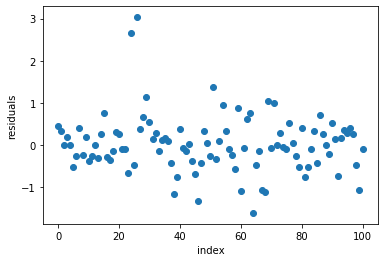

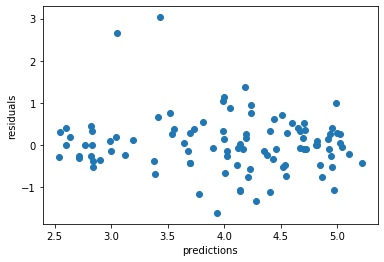

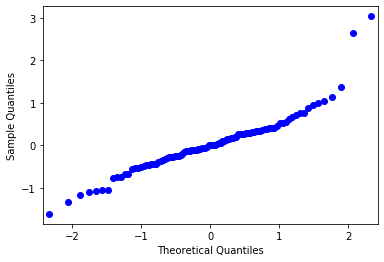

In [29]:
beta = np.mean(trace_a2.get_values("beta", combine=True), axis=0)
preds = beta[0] * X[:, 0] + beta[1] * X[:, 1] + beta[2] * X[:, 2]
resids = y - preds

plt.xlabel("index")
plt.ylabel("residuals")
plt.scatter(np.arange(len(resids)), resids)
_ = plt.show()

plt.xlabel("predictions")
plt.ylabel("residuals")
plt.scatter(preds, resids)
_ = plt.show()

_ = sm.qqplot(resids)

## Comparing Models

### Widely Applicable Information Criteria (WAIC)

The course video talks about the [Deviance Information Criteria (DIC)](https://en.wikipedia.org/wiki/Deviance_information_criterion) which is the posterior mean of the log likelihood with an added penalty for model complexity. 

The PyMC3 analog is the Widely Applicable Information Criteria (WAIC), [attributed to Watanabe (2010)](https://docs.pymc.io/notebooks/model_comparison.html), and defined as a fully Bayesian criterion for estimating out-of-sample expectation, using the computed log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting. The description of WAIC sounds very similar to DIC. Difference between the two is [described here](http://watanabe-www.math.dis.titech.ac.jp/users/swatanab/dicwaic.html), and appears that the main difference is that WAIC has theoretical support but DIC does not.

#### Findings

* In terms of WAIC, `alt_model_2` performs the best (lowest WAIC).
* Results of compare 
  * models are ranked by `waic` (lowest WAIC == best model)
  * `p_waic` is the estimated effective number of parameters 
  * `weights` are the probability of each model given the data
* Results of compareplot
  * unfilled circle is the WAIC value, showing `alt_model_2` has lowest WAIC
  * filled circles show the deviance in WAIC value.

In [30]:
pm.waic(trace_b, baseline_model)

Computed from 15000 by 101 log-likelihood matrix

        Estimate       SE
IC_waic   217.79    30.20
p_waic      5.52        -

There has been a warning during the calculation. Please check the results.

In [31]:
pm.waic(trace_a1, alt_model_1)

Computed from 15000 by 101 log-likelihood matrix

        Estimate       SE
IC_waic   210.95    22.83
p_waic      7.66        -

There has been a warning during the calculation. Please check the results.

In [32]:
pm.waic(trace_a2, alt_model_2)

Computed from 15000 by 101 log-likelihood matrix

        Estimate       SE
IC_waic   195.40    20.81
p_waic      4.52        -

In [33]:
compare_dict = {
    "baseline_model": trace_b,
    "alt_model_1": trace_a1,
    "alt_model_2": trace_a2
}
waic_comps = pm.compare(compare_dict)
waic_comps

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
alt_model_2,0,195.402,4.51853,0,0.91844,30.675,0,False,deviance
alt_model_1,1,210.95,7.65599,15.5482,0.0376763,23.1584,9.61026,True,deviance
baseline_model,2,217.788,5.52077,22.3859,0.0438837,21.2555,16.5292,True,deviance


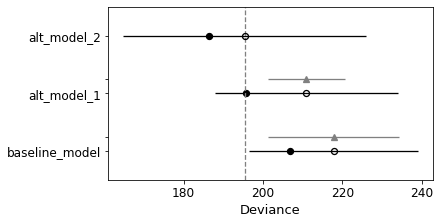

In [34]:
_ = pm.compareplot(waic_comps)

### Leave One Out Cross-Validation (LOO)

Available in PyMC3, not covered in course video. This provides an estimate of out-of-sample predictive fit. As before `alt_model_2` has the best performance.

In [35]:
pm.loo(trace_b, baseline_model)

Computed from 15000 by 101 log-likelihood matrix

       Estimate       SE
IC_loo   217.98    30.33
p_loo      5.61        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       99   98.0%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)         1    1.0%
   (1, Inf)   (very bad)    0    0.0%

In [36]:
pm.loo(trace_a1, alt_model_1)

Computed from 15000 by 101 log-likelihood matrix

       Estimate       SE
IC_loo   211.21    22.95
p_loo      7.79        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      101  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [37]:
pm.loo(trace_a2, alt_model_2)

Computed from 15000 by 101 log-likelihood matrix

       Estimate       SE
IC_loo   195.43    20.82
p_loo      4.53        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      101  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [38]:
loo_comps = pm.compare(compare_dict, ic="LOO")
loo_comps

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
alt_model_2,0,195.431,4.53278,0,0.918645,29.9444,0,False,deviance
alt_model_1,1,211.211,7.78605,15.7798,0.0358971,22.321,9.70117,False,deviance
baseline_model,2,217.976,5.6149,22.5456,0.0454584,20.1194,16.6481,True,deviance


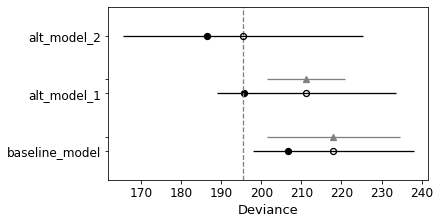

In [39]:
_ = pm.compareplot(loo_comps)